In [12]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Now using device: {device}")

Now using device: cuda


In [14]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [15]:
def corrupt(x, amount):
    # corrupt the input x by mixing with noise according to amount
    
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) #sort shape to braodcast
    
    #amount is continuous from 0 to 1, 0 is no noise (original image), 1 is total corruption
    return x * (1 - amount) + noise * amount

In [16]:
#batch distribution
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#epochs
n_epochs = 3

#create advanced U-Net
net = UNet2DModel(
    sample_size = 28, #target image resolution
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2, #no. of resnet layer in a UNet block
    block_out_channels = (32, 64, 64), 

    down_block_types = (
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),

    up_block_types = (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),

)
net.to(device)

#loss function
loss_fn = nn.MSELoss()

#optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

#record of losses
losses = []


In [18]:
#training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        #corruption
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) #random noise amount
        noisy_x = corrupt(x, noise_amount)

        #prediction
        pred = net(noisy_x, 0).sample #using timestep 0

        #loss
        loss = loss_fn(pred, x)

        #backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        #record loss
        losses.append(loss.item())

    #print average loss per epoch
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch {epoch}: Average loss is {avg_loss:05f}")

Epoch 0: Average loss is 0.019310
Epoch 1: Average loss is 0.012843
Epoch 2: Average loss is 0.011639


tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250], device='cuda:0')


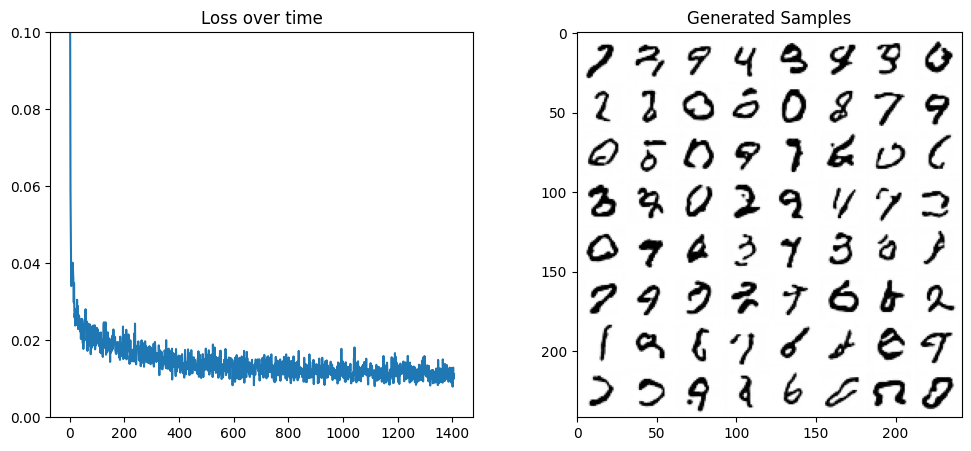

In [19]:
#plot loss and images
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
                        
#losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

#sample images
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps)) #high to low noise amount

    with torch.no_grad():
        pred = net(x, 0).sample #prediction
    
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")
print(noise_amount)

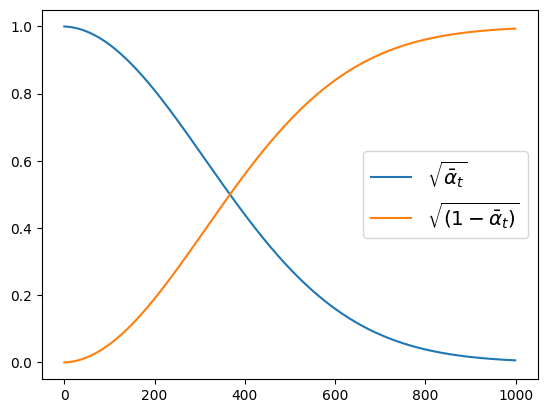

In [20]:
#visualise noise by DDPM
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label = r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu() ** 0.5), label = r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize = "x-large")

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

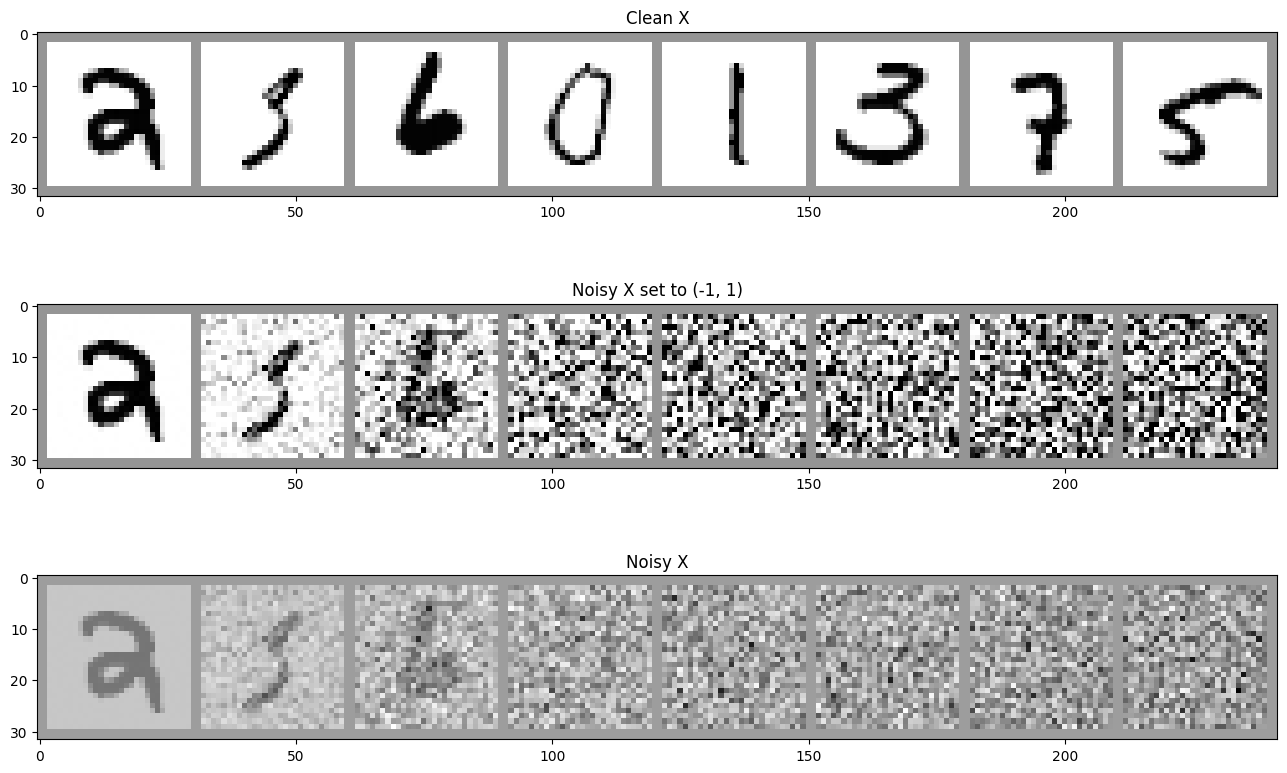

In [27]:
#visualise DDPM noising process for different timesteps
#noise a batch of images
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0 #map to (-1, 1)
print("X shape", xb.shape)

#clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

#add noise with DDPM scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

#show noisy versions
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X set to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")